1. Load the Data

In [38]:
!pip install statsmodels


   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.9 MB 8.4 MB/s eta 0:00:02
   ------------------- -------------------- 4.7/9.9 MB 12.4 MB/s eta 0:00:01
   ------------------------------- -------- 7.9/9.9 MB 13.5 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.9 MB 13.4 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 10.8 MB/s eta 0:00:00


In [2]:
# 基础预处理
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.stats import zscore
from scipy.stats import pearsonr


# 1. 读取和初步清洗
df = pd.read_csv("D1_sensor_data.csv")
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)
df = df.sort_values('published_at')

# 2. 选择列、转数值、过滤
selected_columns = ['published_at', 'temperature', 'hive_power', 'tag_number']
df = df[selected_columns]

# 转换数值类型
numeric_cols = ['temperature', 'hive_power', 'tag_number']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# 过滤特定tag_number
df = df[df['tag_number'] == 202204]

# 去重和缺失值处理
df = df.drop_duplicates(subset='published_at')
df = df.dropna(subset=['temperature', 'hive_power'])

# 3. 设置索引并排序
df = df.set_index('published_at').sort_index()

# 4. 重采样为小时平均并插值补齐
df = df.resample('1h').mean().interpolate(method='linear')

# 5. 添加月份列
df['month'] = df.index.to_period('M').astype(str)

# 6. 标准化处理
df['temp_z'] = zscore(df['temperature'])
df['power_z'] = zscore(df['hive_power'])

# 简单中心化
df['temp_centered'] = df['temperature'] - df['temperature'].mean()
df['power_centered'] = df['hive_power'] - df['hive_power'].mean()

# 7. 恢复索引为列
df = df.reset_index()

# 预览结果
print(df[['published_at', 'temp_z', 'power_z', 'month']].head())

# 检查重采样后是否存在缺失时间段
missing_intervals = df.asfreq('1h').isnull().sum()
print("Missing values after resampling:\n", missing_intervals)

# 确保插值后完全连续
assert df[['temperature', 'hive_power']].isnull().sum().sum() == 0, "存在未处理的缺失值"

               published_at    temp_z   power_z    month
0 2020-05-26 10:00:00+00:00 -0.098172 -1.596646  2020-05
1 2020-05-26 11:00:00+00:00  0.445122 -0.312957  2020-05
2 2020-05-26 12:00:00+00:00  0.547336 -0.426106  2020-05
3 2020-05-26 13:00:00+00:00  0.649549 -0.539255  2020-05
4 2020-05-26 14:00:00+00:00  0.751763 -0.652405  2020-05
Missing values after resampling:
 published_at      1
temperature       1
hive_power        1
tag_number        1
month             1
temp_z            1
power_z           1
temp_centered     1
power_centered    1
dtype: int64


C:\Users\林\AppData\Local\Temp\ipykernel_25524\2071889865.py:37: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df.index.to_period('M').astype(str)


time_diff
0 days 01:00:00    3925
Name: count, dtype: int64
采样频率是否稳定（每小时）: True
               published_at  temperature  hive_power  tag_number    month  \
0 2020-05-26 10:00:00+00:00        28.98      -8.593    202204.0  2020-05   

     temp_z   power_z  temp_centered  power_centered time_diff  interval_check  
0 -0.098172 -1.596646      -0.827594      -16.396949       NaT            True  
存在缺失值的行数： 1


d:\anaconda\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.c

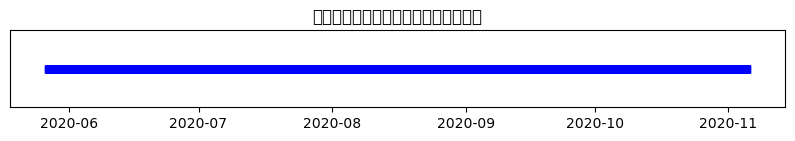

In [3]:
df['time_diff'] = df['published_at'].diff()
print(df['time_diff'].value_counts())

expected_interval = pd.Timedelta('1h')
all_equal = (df['published_at'].diff().dropna() == expected_interval).all()
print("采样频率是否稳定（每小时）:", all_equal)

df['interval_check'] = df['published_at'].diff() != pd.Timedelta('1h')
print(df[df['interval_check']])

missing_rows = df[df.isnull().any(axis=1)]
print("存在缺失值的行数：", len(missing_rows))

plt.figure(figsize=(10, 1))
plt.plot(df['published_at'], np.ones(len(df)), '|', color='blue')
plt.title("时间点分布（理想情况下应为等间隔）")
plt.yticks([])
plt.show()


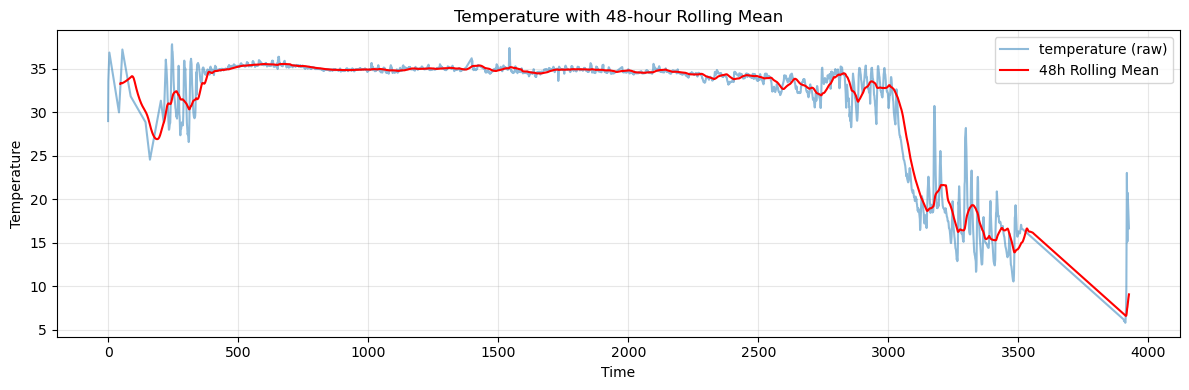

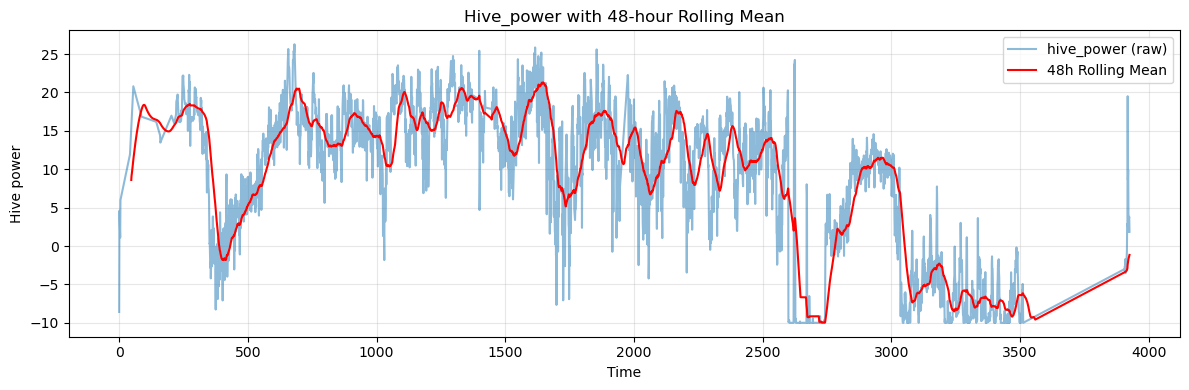

In [4]:
import matplotlib.pyplot as plt

variables = ['temperature', 'hive_power']
window_hours = 48  # 两天滑动窗口

for var in variables:
    plt.figure(figsize=(12, 4))
    plt.plot(df[var], label=f'{var} (raw)', alpha=0.5)
    plt.plot(df[var].rolling(window=window_hours).mean(), 
             label=f'{window_hours}h Rolling Mean', color='red')
    plt.title(f"{var.capitalize()} with {window_hours}-hour Rolling Mean")
    plt.xlabel("Time")
    plt.ylabel(var.replace('_', ' ').capitalize())
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


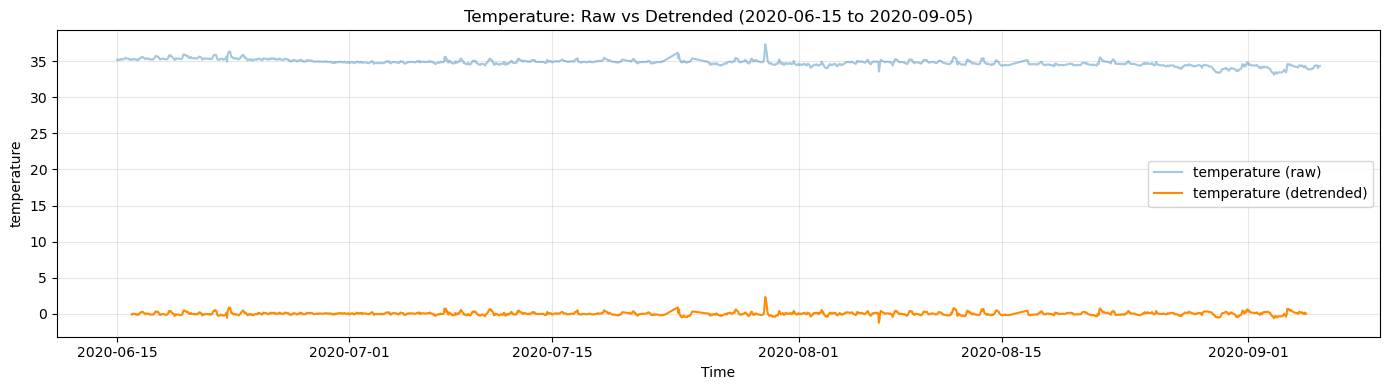

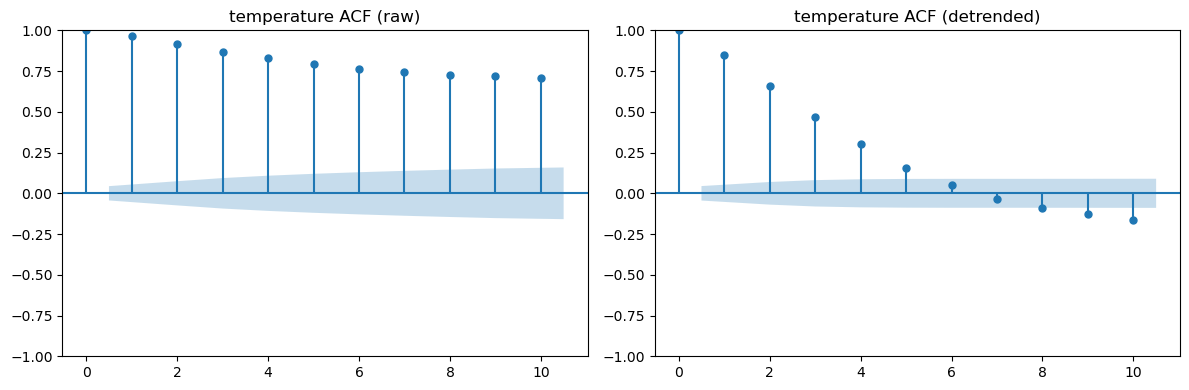

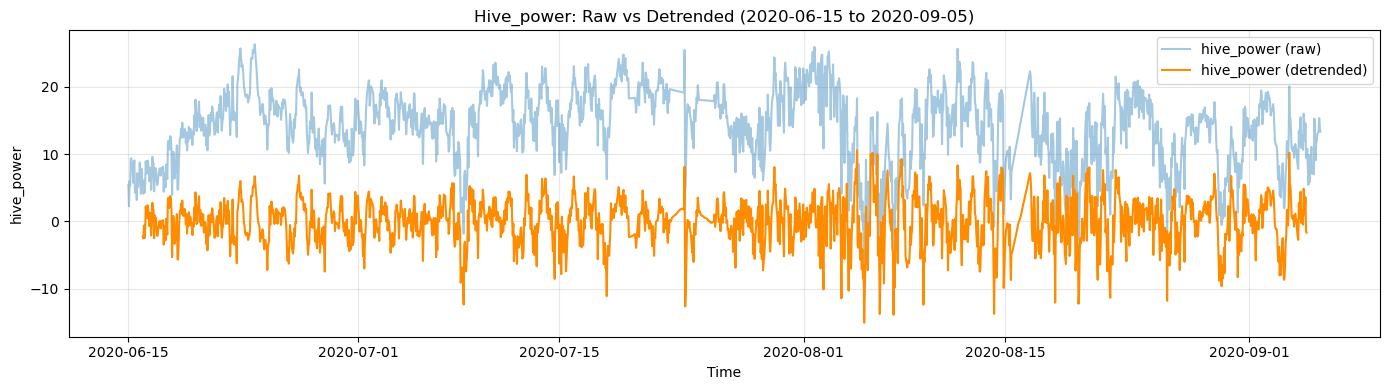

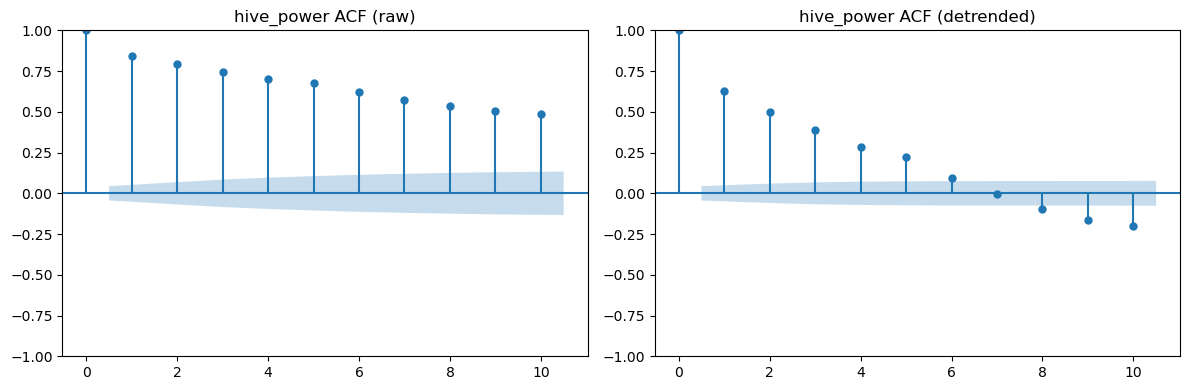

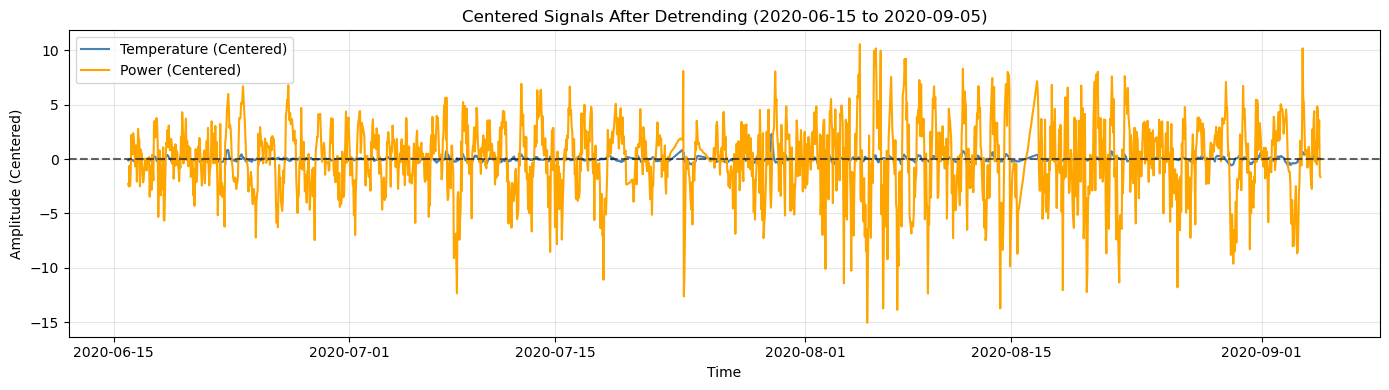

temperature lag-1 ACF (raw): 0.963, (detrended): 0.849
hive_power lag-1 ACF (raw): 0.845, (detrended): 0.626


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

# 假设 df 已加载，且 published_at 是索引或列

# 确保索引是 datetime 类型
if 'published_at' in df.columns:
    df['published_at'] = pd.to_datetime(df['published_at'])
    df.set_index('published_at', inplace=True)

# 选取时间窗口
start_date = '2020-06-15'
end_date = '2020-09-05'
df_window = df.loc[start_date:end_date].copy()

variables = ['temperature', 'hive_power']
window_size = 48

def rolling_detrend(series, window):
    trend = series.rolling(window=window, center=True).mean()
    return series - trend

def center_series(series):
    return series - series.mean()

for var in variables:
    df_window[f'{var}_detrended'] = rolling_detrend(df_window[var], window_size)
    df_window[f'{var}_centered'] = center_series(df_window[f'{var}_detrended'])

    # 可视化原始 vs 去趋势
    plt.figure(figsize=(14, 4))
    plt.plot(df_window[var], label=f'{var} (raw)', alpha=0.4)
    plt.plot(df_window[f'{var}_detrended'], label=f'{var} (detrended)', color='darkorange')
    plt.title(f'{var.capitalize()}: Raw vs Detrended ({start_date} to {end_date})')
    plt.xlabel('Time')
    plt.ylabel(var)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ACF 比较，确保数据量充足
    raw_data = df_window[var].dropna()
    detr_data = df_window[f'{var}_detrended'].dropna()

    max_lags = 10
    raw_nlags = min(max_lags, len(raw_data)-1) if len(raw_data) > 1 else 0
    detr_nlags = min(max_lags, len(detr_data)-1) if len(detr_data) > 1 else 0

    if raw_nlags > 0 and detr_nlags > 0:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        plot_acf(raw_data, ax=axes[0], lags=raw_nlags, title=f'{var} ACF (raw)')
        plot_acf(detr_data, ax=axes[1], lags=detr_nlags, title=f'{var} ACF (detrended)')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: Not enough data points to plot ACF for {var}")

# 中心化信号对比
plt.figure(figsize=(14, 4))
plt.plot(df_window['temperature_centered'], label='Temperature (Centered)', color='steelblue')
plt.plot(df_window['hive_power_centered'], label='Power (Centered)', color='orange')
plt.axhline(0, linestyle='--', color='black', alpha=0.6)
plt.title(f'Centered Signals After Detrending ({start_date} to {end_date})')
plt.ylabel('Amplitude (Centered)')
plt.xlabel('Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 计算并打印 lag-1 ACF
for var in variables:
    raw_data = df_window[var].dropna()
    detr_data = df_window[f'{var}_detrended'].dropna()

    if len(raw_data) > 1:
        raw_acf_vals = acf(raw_data, nlags=1)
        raw_lag1 = raw_acf_vals[1]
    else:
        raw_lag1 = np.nan

    if len(detr_data) > 1:
        detr_acf_vals = acf(detr_data, nlags=1)
        detr_lag1 = detr_acf_vals[1]
    else:
        detr_lag1 = np.nan

    print(f"{var} lag-1 ACF (raw): {raw_lag1:.3f}, (detrended): {detr_lag1:.3f}")



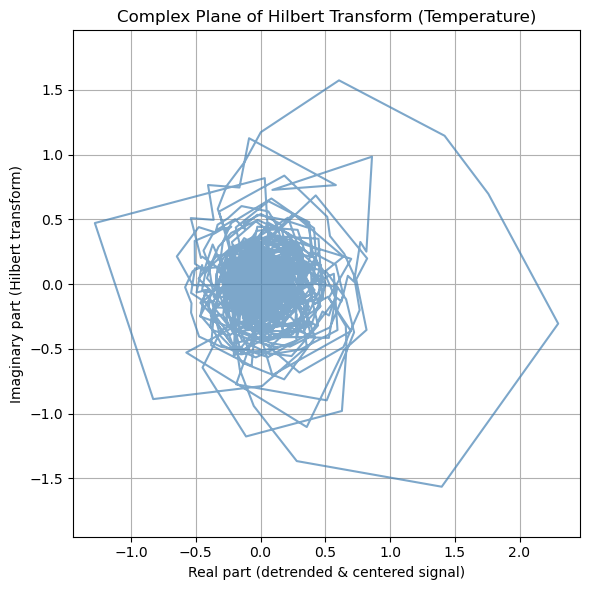

In [6]:
# Hilbert Transform and Phase Calculation

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# 取去趋势且中心化的温度信号（保证无NaN）
signal = df_window['temperature_centered'].dropna().values

# 计算解析信号 (analytic signal)
analytic_signal = hilbert(signal)
real_part = np.real(analytic_signal)
imag_part = np.imag(analytic_signal)

# 复平面相图
plt.figure(figsize=(6, 6))
plt.plot(real_part, imag_part, color='steelblue', alpha=0.7)
plt.xlabel('Real part (detrended & centered signal)')
plt.ylabel('Imaginary part (Hilbert transform)')
plt.title('Complex Plane of Hilbert Transform (Temperature)')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()



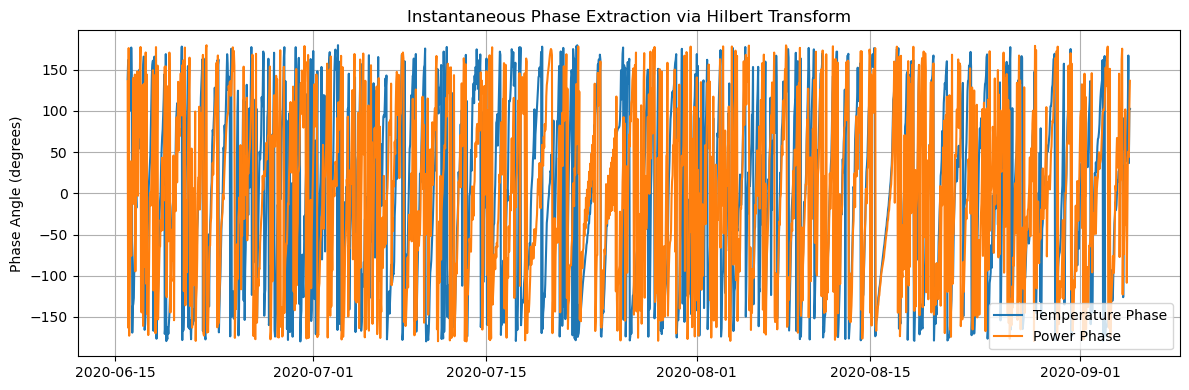

In [46]:
# Hilbert Transform & Instantaneous Phase Extraction

from scipy.signal import hilbert
import numpy as np
import matplotlib.pyplot as plt

# 取去趋势且中心化后的信号，并确保无缺失（时间索引对齐）
temp_signal = df_window['temperature_centered'].dropna()
power_signal = df_window['hive_power_centered'].dropna()

# Hilbert 解析信号
analytic_temp = hilbert(temp_signal)
analytic_power = hilbert(power_signal)

# 计算瞬时相位
temp_phase = np.angle(analytic_temp)
power_phase = np.angle(analytic_power)

# 绘图，x轴用对应的时间索引
plt.figure(figsize=(12, 4))
plt.plot(temp_signal.index, np.rad2deg(temp_phase), label='Temperature Phase')
plt.plot(power_signal.index, np.rad2deg(power_phase), label='Power Phase')
plt.ylabel('Phase Angle (degrees)')
plt.title('Instantaneous Phase Extraction via Hilbert Transform')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


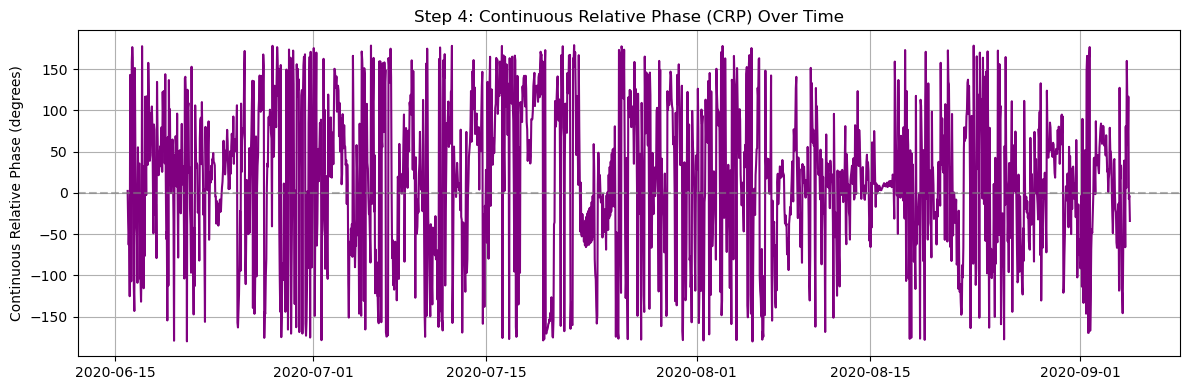

In [47]:
# 计算连续相对相位 CRP（弧度展开并映射到[-180,180]区间）
crp = np.unwrap(temp_phase - power_phase)
crp_deg = np.rad2deg((crp + np.pi) % (2 * np.pi) - np.pi)

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(temp_signal.index, crp_deg, color='purple')
plt.axhline(0, linestyle='--', color='gray', alpha=0.6)
plt.ylabel('Continuous Relative Phase (degrees)')
plt.title('Step 4: Continuous Relative Phase (CRP) Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


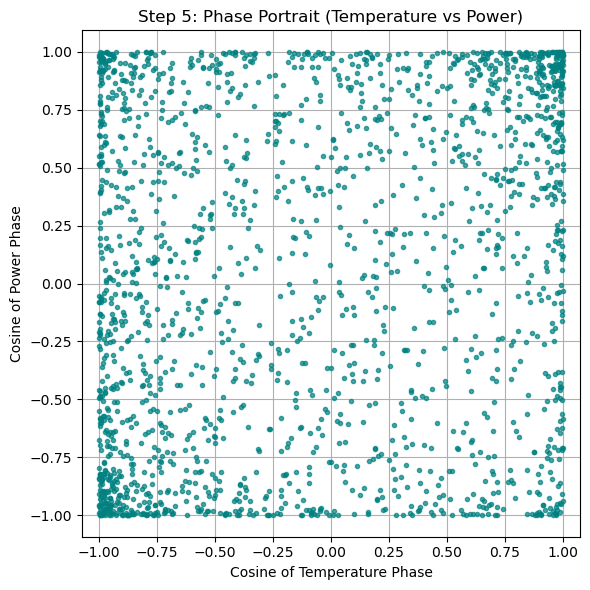

In [48]:
plt.figure(figsize=(6, 6))
plt.plot(np.cos(temp_phase), np.cos(power_phase), 
         alpha=0.7, marker='.', linestyle='None', color='teal')
plt.xlabel('Cosine of Temperature Phase')
plt.ylabel('Cosine of Power Phase')
plt.title('Step 5: Phase Portrait (Temperature vs Power)')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


In [49]:
from scipy.stats import kurtosis

# 先去除可能的NaN值
crp_deg_clean = df['crp_deg'].dropna()

def vector_strength(phases_deg):
    phases_rad = np.deg2rad(phases_deg)
    return np.abs(np.mean(np.exp(1j * phases_rad)))

vs = vector_strength(crp_deg_clean)
kur = kurtosis(crp_deg_clean, fisher=True)  # fisher=True表示返回峰度减3（正态分布峰度为0）

print(f"Step 5 Metrics → Vector Strength: {vs:.3f}, Kurtosis of CRP: {kur:.2f}")


Step 5 Metrics → Vector Strength: 0.578, Kurtosis of CRP: 0.80


In [50]:
# 确保crp_deg列存在且对齐索引
crp_deg = crp_deg[:len(df)]  # 截取长度匹配索引（或基于之前长度）

# 转成Series方便处理
crp_series = pd.Series(crp_deg, index=df.index[:len(crp_deg)])

lead_ratio = (crp_series > 0).mean()
lag_ratio = (crp_series < 0).mean()

print(f"温度领先功率占比: {lead_ratio:.2%}")
print(f"温度滞后功率占比: {lag_ratio:.2%}")


温度领先功率占比: 60.82%
温度滞后功率占比: 39.18%


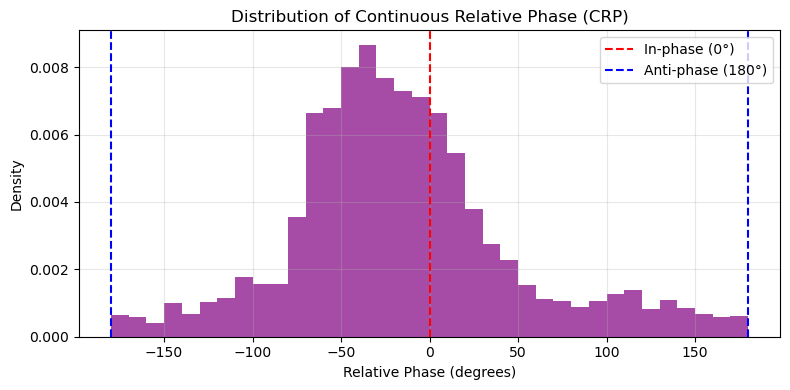

In [ ]:
# df['crp_deg'] = crp_deg[:len(df)]

plt.figure(figsize=(8, 4))
plt.hist(df['crp_deg'].dropna(), bins=36, range=(-180, 180), density=True, alpha=0.7, color='purple')
plt.axvline(0, color='r', linestyle='--', label='In-phase (0°)')
plt.axvline(180, color='b', linestyle='--', label='Anti-phase (180°)')
plt.axvline(-180, color='b', linestyle='--')  # 负180°也标出来更完整
plt.xlabel('Relative Phase (degrees)')
plt.ylabel('Density')
plt.title('Distribution of Continuous Relative Phase (CRP)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


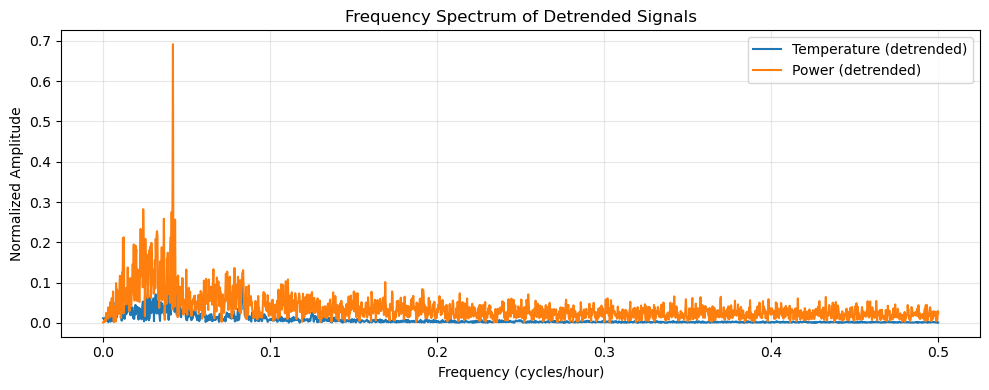

In [52]:
# 温度与功率的信号是否表现为节律性变化（rhythmic）

from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# 取去趋势后数据，并裁剪统一长度
signal_temp = df['temperature_detrended'].dropna().values
signal_power = df['hive_power_detrended'].dropna().values
min_len = min(len(signal_temp), len(signal_power))
signal_temp = signal_temp[:min_len]
signal_power = signal_power[:min_len]

fs = 1  # 采样频率：1 sample/hour
N = min_len

# 计算频率轴（正负频率）
freqs = fftfreq(N, d=1/fs)

# 计算 FFT 幅值，归一化
fft_temp = np.abs(fft(signal_temp)) / N
fft_power = np.abs(fft(signal_power)) / N

# 只取正频率部分
pos_mask = freqs >= 0
freqs_pos = freqs[pos_mask]
fft_temp_pos = fft_temp[pos_mask]
fft_power_pos = fft_power[pos_mask]

# 绘制频谱
plt.figure(figsize=(10, 4))
plt.plot(freqs_pos, fft_temp_pos, label='Temperature (detrended)')
plt.plot(freqs_pos, fft_power_pos, label='Power (detrended)')
plt.xlabel('Frequency (cycles/hour)')
plt.ylabel('Normalized Amplitude')
plt.title('Frequency Spectrum of Detrended Signals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




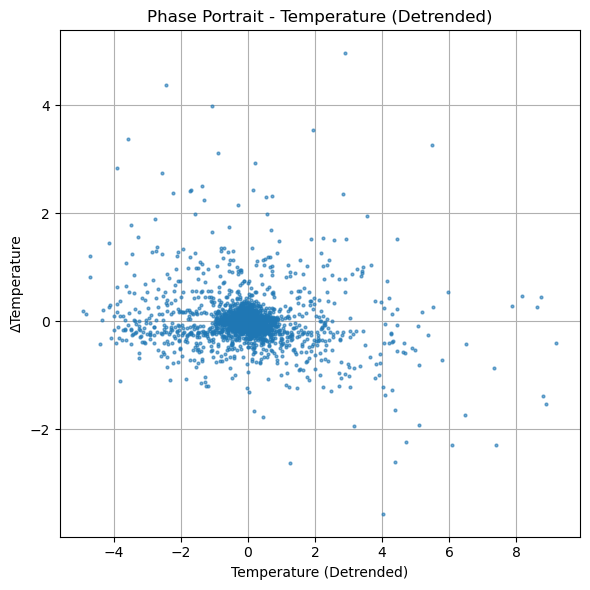

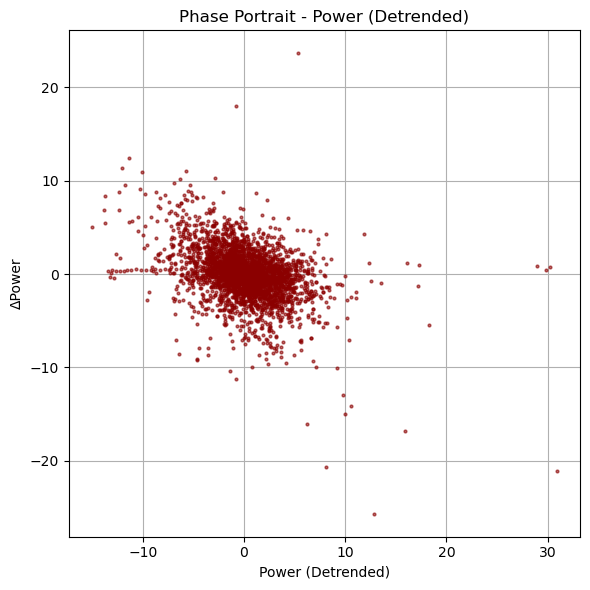

In [53]:
# 相空间图 位移：温度

temp_detrended = df['temperature_detrended'].dropna().values
power_detrended = df['hive_power_detrended'].dropna().values

# 计算速度（差分）
v_temp = np.diff(temp_detrended)
v_power = np.diff(power_detrended)

# 位移取对应长度（去掉最后一个点）
x_temp = temp_detrended[:-1]
x_power = power_detrended[:-1]

# 温度相空间图
plt.figure(figsize=(6, 6))
plt.plot(x_temp, v_temp, 'o', markersize=2, alpha=0.6)
plt.title("Phase Portrait - Temperature (Detrended)")
plt.xlabel("Temperature (Detrended)")
plt.ylabel("ΔTemperature")
plt.grid(True)
plt.tight_layout()
plt.show()

# 功率相空间图
plt.figure(figsize=(6, 6))
plt.plot(x_power, v_power, 'o', markersize=2, alpha=0.6, color='darkred')
plt.title("Phase Portrait - Power (Detrended)")
plt.xlabel("Power (Detrended)")
plt.ylabel("ΔPower")
plt.grid(True)
plt.tight_layout()
plt.show()




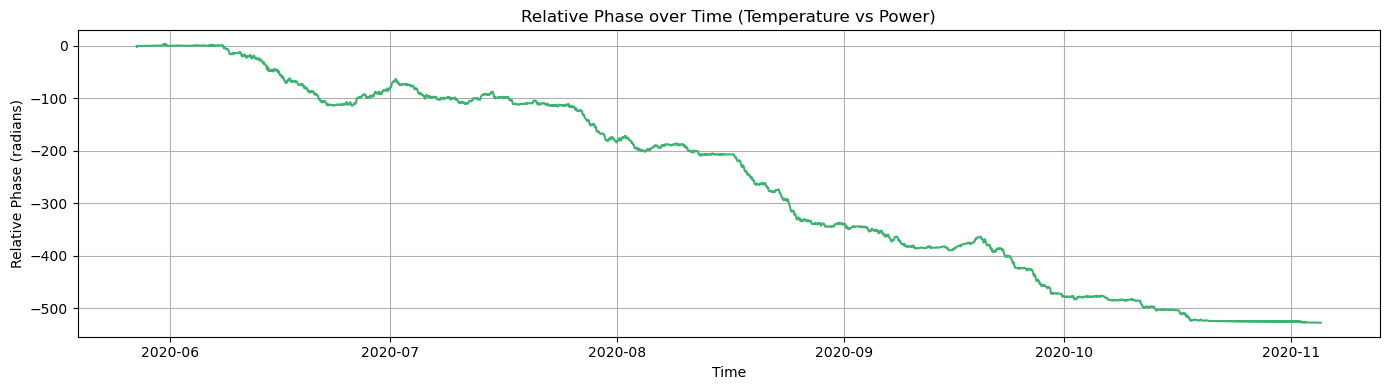

In [54]:
# 两个连续时间序列之间的协调关系（Coordination）
# Hilbert变换相位提取
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# 标准化去趋势信号（Z-score）
df['temp_z'] = (df['temperature_detrended'] - df['temperature_detrended'].mean()) / df['temperature_detrended'].std()
df['power_z'] = (df['hive_power_detrended'] - df['hive_power_detrended'].mean()) / df['hive_power_detrended'].std()

# 去除缺失值，确保两个序列索引一致
temp_z = df['temp_z'].dropna()
power_z = df['power_z'].dropna()

# 取两序列索引交集，保证时间对齐
common_index = temp_z.index.intersection(power_z.index)
temp_z_aligned = temp_z.loc[common_index]
power_z_aligned = power_z.loc[common_index]

# Hilbert变换提取瞬时相位
temp_phase = np.angle(hilbert(temp_z_aligned))
power_phase = np.angle(hilbert(power_z_aligned))

# 计算相对相位并展开
relative_phase = np.unwrap(temp_phase - power_phase)

# 保存结果方便后续分析
df_phase = pd.DataFrame({
    'relative_phase': relative_phase
}, index=common_index)

# 绘制相对相位时间序列
plt.figure(figsize=(14, 4))
plt.plot(df_phase.index, df_phase['relative_phase'], color='mediumseagreen')
plt.title('Relative Phase over Time (Temperature vs Power)')
plt.xlabel('Time')
plt.ylabel('Relative Phase (radians)')
plt.grid(True)
plt.tight_layout()
plt.show()



In [25]:
# phase coupling 两者之间是否存在相位耦合
# 温度与功率是否存在稳定的相位关系

from scipy.signal import hilbert
from numpy import angle, unwrap, degrees

# 获取相位角
analytic_temp = hilbert(df['temp_centered'])
analytic_power = hilbert(df['power_centered'])
phase_temp = unwrap(angle(analytic_temp))
phase_power = unwrap(angle(analytic_power))

# 相对相位（Continuous Relative Phase）
crp = np.abs(degrees(phase_temp - phase_power)) % 360
df['crp'] = crp

# 可视化
plt.figure(figsize=(10,4))
plt.plot(df['published_at'], df['crp'])
plt.ylabel('Relative Phase (degrees)')
plt.title('Continuous Relative Phase Over Time')
plt.show()


KeyError: 'published_at'

<Figure size 1000x400 with 0 Axes>

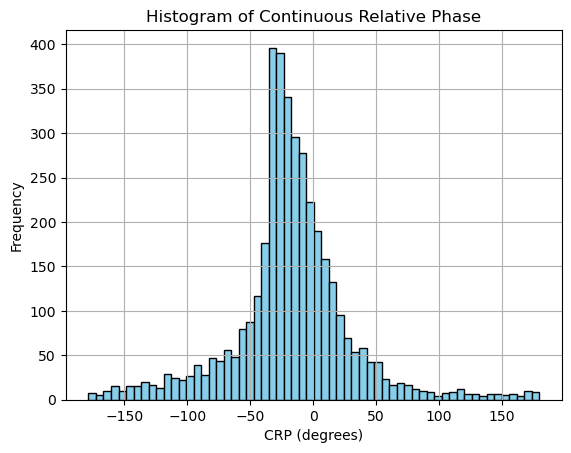

In [ ]:
# CRP分布分析
plt.hist(df['CRP_deg'], bins=60, color='skyblue', edgecolor='black')
plt.xlabel("CRP (degrees)")
plt.ylabel("Frequency")
plt.title("Histogram of Continuous Relative Phase")
plt.grid(True)
plt.show()


d:\anaconda\envs\myenv\Lib\site-packages\pandas\core\window\rolling.py:371: ComplexWarning: Casting complex values to real discards the imaginary part
  values = ensure_float64(values)


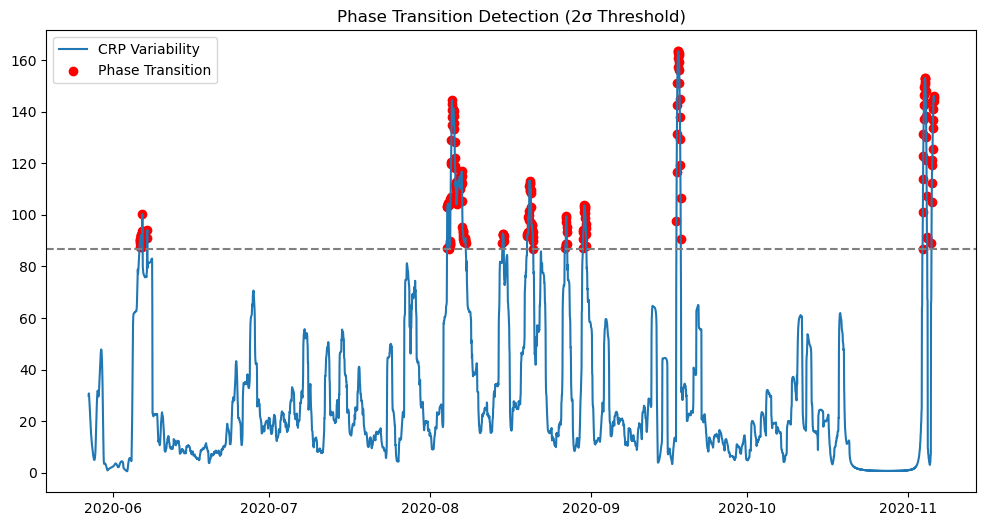

In [ ]:
# 归一化处理
# 振幅归一化
df['temp_amp_norm'] = df['temp_amp'] / df['temp_amp'].max()
df['power_amp_norm'] = df['power_amp'] / df['power_amp'].max()

# 相位同步指数 (PSI)
df['psi'] = np.abs(np.exp(1j*df['relative_phase']).rolling(24).mean())

# =============== 6.灵活性/刚性 ===============
# 使用CRP标准差量化
df['flexibility'] = 1 / (1 + df['crp_std'])  # 值域0-1，越大越刚性

# 滑动窗口熵值计算
def phase_entropy(phases, bins=12):
    hist = np.histogram(phases, bins=bins, range=(-np.pi, np.pi))[0]
    return entropy(hist)/np.log(bins)  # 归一化熵

df['phase_entropy'] = df['relative_phase'].rolling(24*7).apply(phase_entropy)

# =============== 7.相变检测 ===============
# 基于CRP标准差突变检测
threshold = df['crp_std'].mean() + 2*df['crp_std'].std()
phase_transitions = df[df['crp_std'] > threshold]

# 标记相变点
plt.figure(figsize=(12, 6))
plt.plot(df['published_at'], np.rad2deg(df['crp_std']), label='CRP Variability')
plt.scatter(phase_transitions['published_at'], 
            np.rad2deg(phase_transitions['crp_std']),
            c='red', label='Phase Transition')
plt.axhline(np.rad2deg(threshold), linestyle='--', color='grey')
plt.title("Phase Transition Detection (2σ Threshold)")
plt.legend()
plt.show()

C:\Users\林\AppData\Local\Temp\ipykernel_31044\207049916.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['published_at'].dt.to_period('M').astype(str)


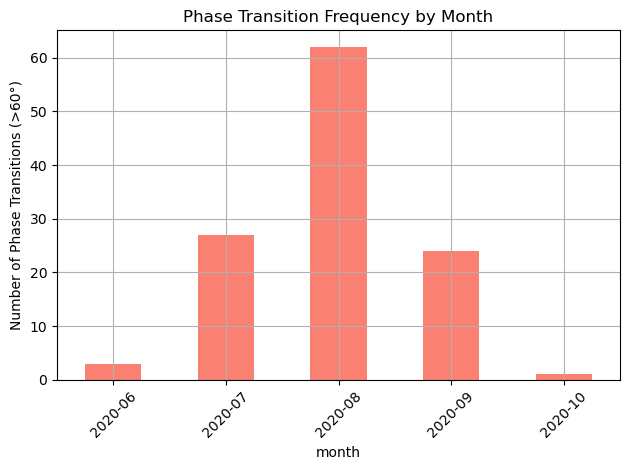

In [ ]:
# 按月分组相变频率
df['crp_diff'] = df['CRP_deg'].diff().abs()
df['month'] = df['published_at'].dt.to_period('M').astype(str)
monthly_transitions = df[df['crp_diff'] > 60].groupby('month').size()

monthly_transitions.plot(kind='bar', color='salmon')
plt.ylabel("Number of Phase Transitions (>60°)")
plt.title("Phase Transition Frequency by Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


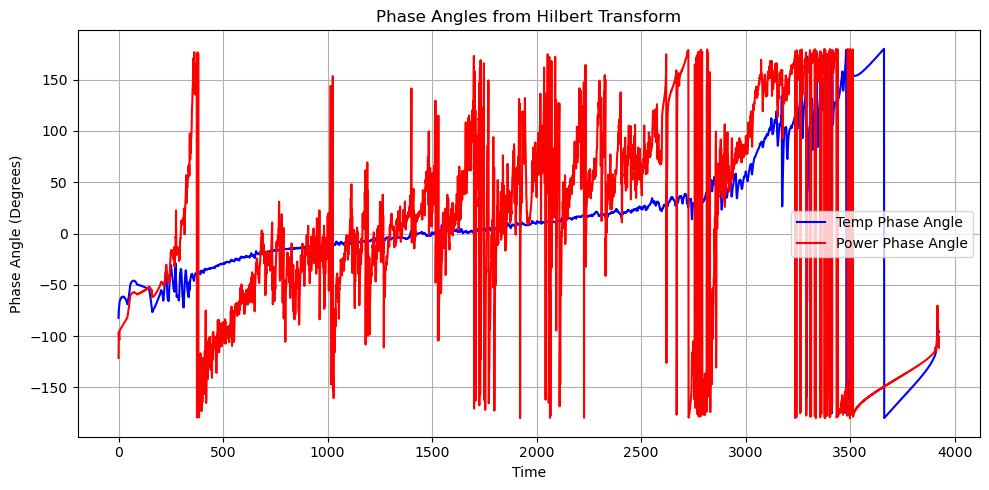

In [ ]:
# 温-功相位角时间序列对比
ht_temp = hilbert(temperature_c)
ht_power = hilbert(power_c)

phase_temp = np.angle(ht_temp)
phase_power = np.angle(ht_power)

# 可视化瞬时相位
plt.figure(figsize=(10, 5))
plt.plot(time, np.rad2deg(phase_temp), label='Temp Phase Angle', color='blue')
plt.plot(time, np.rad2deg(phase_power), label='Power Phase Angle', color='red')
plt.title("Phase Angles from Hilbert Transform")
plt.xlabel("Time")
plt.ylabel("Phase Angle (Degrees)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
